## Mimic EDA
#### Predicting and Understanding Unexpected Respiratory Decompensation in Critical Care Using Sparse and Heterogeneous Clinical Data

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import mimic_utils as mimic
import magec_utils as mg
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

random.seed(22891)

%matplotlib inline

Using TensorFlow backend.


### MIMIC-III Data

In [2]:
# MIMIC-III
df = mimic.get_mimic_data()

### Get annotation data (if any) for patients in our cohort w/ advanced lung or heart disease

In [3]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')
df_anno = df_anno[((df_anno['ADVANCED.LUNG.DISEASE'] == 1) | 
                  (df_anno['ADVANCED.HEART.DISEASE'] == 1)) & 
                  (df_anno['ADVANCED.CANCER'] == 0)]
users = list(set(df.subject_id.unique()).intersection(set(df_anno.SUBJECT_ID.unique())))
len(users)

47

In [4]:
np.save('case_users', users)

### MIMIC-III Data Engineering

In [5]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

features = vitals+labs

# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df)
# Data featurized as time-series
df_time = mimic.get_ml_series_data(df)

_, x_validation, stsc, _, xst_validation, _, Y_validation = mimic.train_valid_ml(df_ml, 
                                                                                 include_valid='case_users.npy')

stsc2, series_means, _, df_series_valid, _, _, xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

In [6]:
series_means

glucose_mean                141.827799
ptt                          35.473116
pulmonary_circulation         0.064002
tempc_mean                   36.765522
diasbp_mean                  62.553436
resprate_mean                19.664887
albumin                       3.379839
spo2_mean                    96.682270
meanbp_mean                  79.125184
bilirubin                     1.591420
pt                           16.078363
gender                        0.562583
glucose                     160.903257
hemoglobin                   11.875867
magnesium                     1.947650
congestive_heart_failure      0.271010
chronic_pulmonary             0.199298
phosphate                     3.566423
heartrate_mean               85.105305
creatinine                    1.546555
wbc                          12.167143
platelet                    250.565683
age                          62.244080
bicarbonate                  23.595292
sysbp_mean                  120.738031
aniongap                 

### Load cohort data (demographics, vitals, labs and co-morbidities)

In [7]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

conn = engine.connect()
schema_name = 'mimiciii'
conn.execute('SET search_path to ' + schema_name)

In [8]:
df_cohort = pd.read_sql("select * from mimic_users_study;", conn)

### Get notes for patients in our cohort

In [9]:
from mimic_queries import notes_query
df_notes = pd.read_sql(notes_query(prior_hours=48), conn)

### Get meds for patients in our cohort

In [10]:
from mimic_queries import meds_query
df_meds = pd.read_sql(meds_query(prior_hours=48), conn)

In [11]:
conn.close()

### Get MAgEC results for validation data (2128 patients)

In [12]:
joined = pd.read_csv('time_mimic_magecs_valid.csv')
joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 
                                       'orig_prob_rf', 'orig_prob_lstm']].apply(np.mean, 1)

In [13]:
joined.case.nunique()

2128

### Cases with most potential

In [14]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')

In [21]:
def print_notes(case):
    print('\n***NEXT NOTE***\n\n'.join(df_notes[df_notes.subject_id==case].\
                                   sort_values('charttime')['text'].values.tolist()))
    
def make_panel(case, t_0=None):
    t_min = df_cohort[df_cohort.subject_id==case]['timepoint'].min()
    t_max = df_cohort[df_cohort.subject_id==case]['timepoint'].max()
    print(t_min, t_max)
    timepoint = t_min if t_0 is None else t_0
    mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
                  models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)
    
def best_feature(data, cols):
    models = list(set([c.split('_')[-1] for c in cols]))
    features = list(set(['_'.join(c.split('_')[1:-2]) for c in cols]))  
    best_feat = ''
    new_risk = None
    for feat in features:
        feat_risks = []
        orig_probs = []
        for model in models:
            magec = model + '_' + feat
            perturb = 'perturb_' + feat + '_prob_' + model
            orig = 'orig_prob_' + model
            if magec in data and perturb in data and orig in data:
                magec = data[magec]
                perturb = data[perturb]
                orig = data[orig]
                feat_risks.append(perturb)
                orig_probs.append(orig)
        # model average 
        feat_risk = np.mean(feat_risks)
        orig_prob = np.mean(orig_probs)
        if new_risk is None or feat_risk < new_risk and feat_risk < orig_prob:
            new_risk = feat_risk
            best_feat = feat
    return pd.Series((best_feat, new_risk), index=['best_feat', 'new_risk'])

In [22]:
prob_cols = [c for c in joined.columns if c.startswith('perturb')]

In [23]:
joined[['best_feat', 'new_risk']] = joined.apply(lambda x: best_feature(x, prob_cols), axis=1)

In [24]:
predicate = (joined.orig_prob_ensemble > 0.5) & (joined.new_risk < 0.5)

my_cols = ['case', 'timepoint', 'orig_prob_ensemble', 'best_feat', 'new_risk']

joined[predicate][my_cols].sort_values('new_risk').head()

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
10839,15044,12,0.549959,meanbp_mean,0.122119
13061,18250,5,0.556930,spo2_mean,0.123945
12515,17596,11,0.514156,meanbp_mean,0.126662
4058,5860,11,0.535313,resprate_mean,0.146461
4057,5860,12,0.506284,resprate_mean,0.153252


In [25]:
joined[predicate]['best_feat'].value_counts()

resprate_mean     984
lactate           368
meanbp_mean       365
bilirubin         155
heartrate_mean    148
ptt               111
glucose_mean       50
spo2_mean          46
diasbp_mean        44
albumin            30
aniongap           24
tempc_mean         22
phosphate          21
platelet           15
sysbp_mean         10
magnesium           7
bicarbonate         6
sodium              4
inr                 4
chloride            3
bun                 2
creatinine          1
wbc                 1
pt                  1
Name: best_feat, dtype: int64

In [26]:
joined[predicate][['best_feat', 'new_risk']].groupby('best_feat').mean().\
    sort_values('new_risk').head(10)

,new_risk
best_feat,
spo2_mean,0.392355
resprate_mean,0.406148
meanbp_mean,0.407277
sysbp_mean,0.407364
magnesium,0.410702
ptt,0.424390
diasbp_mean,0.427088
phosphate,0.427166
heartrate_mean,0.429840


### Is sysbp_mean ever identified by MAgEC w/ estimated risk below 0.5?

In [27]:
joined[predicate][joined[predicate]['best_feat'] == 'sysbp_mean'][my_cols].\
    sort_values('new_risk').head(10)

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
14075,19845,15,0.526594,sysbp_mean,0.353429
22050,30591,11,0.502281,sysbp_mean,0.358490
22051,30591,10,0.517878,sysbp_mean,0.383553
16262,23121,16,0.586907,sysbp_mean,0.385466
16268,23121,7,0.510494,sysbp_mean,0.411352
14070,19845,21,0.500272,sysbp_mean,0.412268
16260,23121,18,0.557247,sysbp_mean,0.418320
16258,23121,20,0.560218,sysbp_mean,0.440637
14068,19845,24,0.565455,sysbp_mean,0.453739
24197,41251,9,0.528327,sysbp_mean,0.456383


### Time-series plot

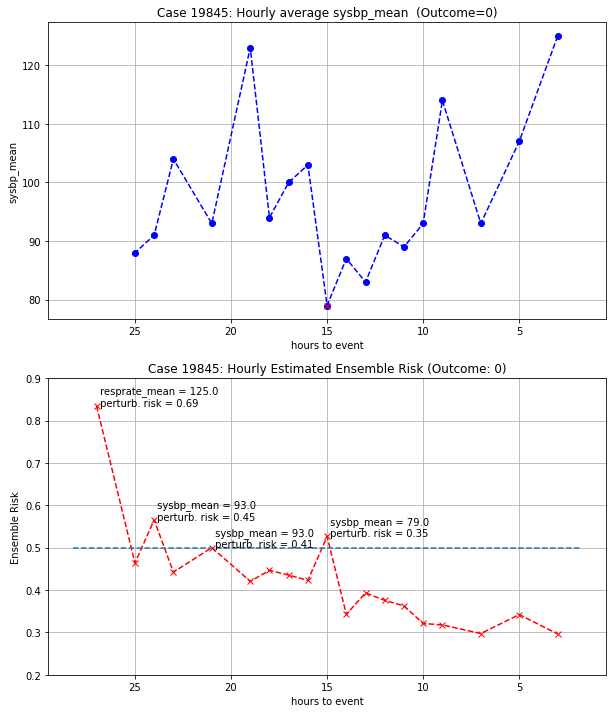

In [37]:
index = 14075
case = 19845
mimic.feat_plot(joined, df_cohort, index)

In [38]:
print_notes(case)

CCU
ADMIT NOTE
THIS IS A 49 YR OLD OBESE MALE ADM VIA THE EW >>> THE CATH LAB >> TO THE CCU S/P CATH


PMHX IDDM TIMES 20 YRS
THYROIDECTOMY FOR GOITER
OBESITY
SILENT MI

ALLERGY TO DEMEROL AND PERCOCETS


TO THE EW ON [**6-22**] WITH C/O'S OF CHEST AND SHOULDER PAIN ..AND INCREASED SOB...PT  WAS FOUND TO BE IN A-FLUTTER WITH ASSOC HYPOTENSION ..CARDIOVERTED  SUCCESSFULLY TO SR-ST AFTER 4 TH ATTEMPT AT 360J..BUT HYPOTENSION CONTINUED DESPITE  4L IVF ..REQUIRED HIGH DOSE LEVOPHED ..CARDIOGENIC SHOCK ..TO THE CATH LAB SHOWING 3VD ..INCLUDING 50% DISTAL LM...PA NUMBERS NOT BAD ..PCW 15 ..PAD 12 ....IAB  PLACED IN LEFT GROIN ...[**Last Name (un) 1787**] CONSULTED RECOMMENDING LAD / RAMUS ..PTCA AND STENT ..BECAUSE DISTAL TARGETS ARE VERY POOR ..AND [**Month (only) **] NOT BE GRAFTABLE ..IF HIS EF IMPROVES THE RISK OF CABG WOULD BE MUCH LESS  ...

TO THE CCU WITHOUT CHEST PAIN, SOB  OR NAUSEA ..
CV HR 70'S  .SR ..WITHOUT ECTOPY ...IAB WITH GOOD AUGMENTATION / UNLOADING 8-12 PTS ...IAB  #'S P

In [49]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours', 'event_time',
        'age', 'gender', 'ethnicity']

data = df_cohort[(df_cohort.subject_id==case) & (df_cohort.timepoint==15)][cols]
data

,subject_id,timepoint,admittime,admission_type,los_icu,diagnosis,curr_service,dischtime,mort_icu,mv_start,mv_end,mv_hours,event_time,age,gender,ethnicity
203795,19845,15,2136-06-22 22:47:00,EMERGENCY,3.0,MYOCARDIAL INFARCTION-ATRIAL FLUTTER,CMED,2136-08-06 13:47:00,0,NaT,NaT,NaN,2136-06-24 01:48:00,49.0,1,white


In [112]:
txt1 = (data.event_time - datetime.timedelta(hours=int(data.timepoint.values[0])) -
        data.admittime 
       ).iloc[0]

txt1 = (txt1.days)*24 + (txt1.seconds) // 3600

txt2 = (data.event_time - datetime.timedelta(hours=3) -
        data.admittime 
       ).iloc[0]

txt2 = (txt2.days)*24 + (txt2.seconds) // 3600

In [113]:
txt1, txt2

(12, 24)

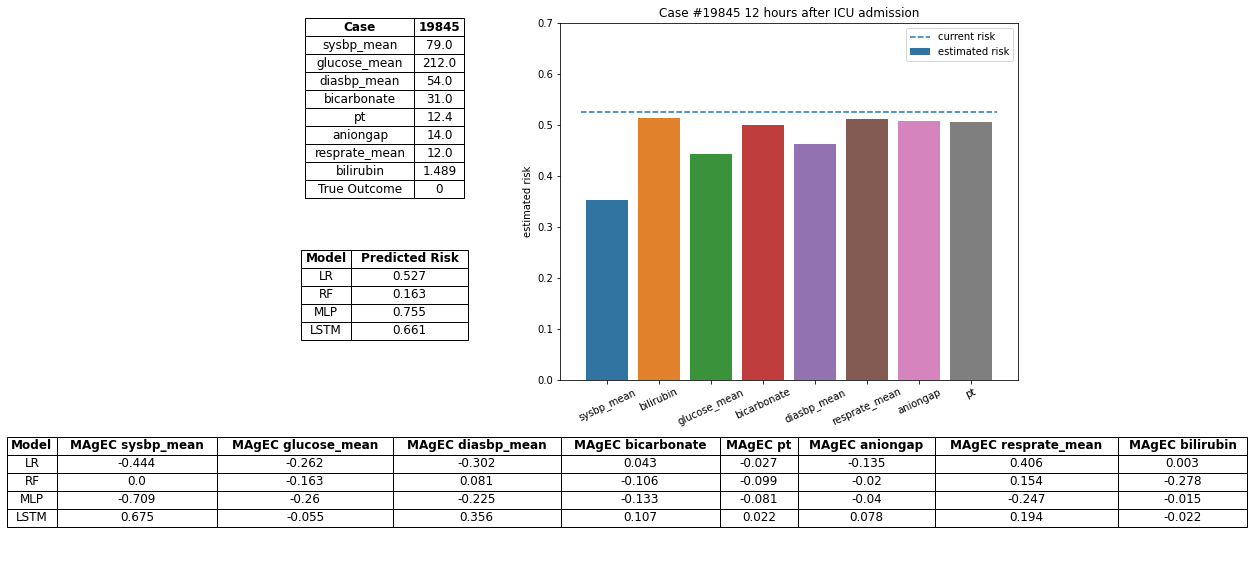

In [116]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=int(data.timepoint.values[0]),
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, int(data.timepoint.values[0])), 
              title='Case #{} {} hours after ICU admission'.format(case, txt1))

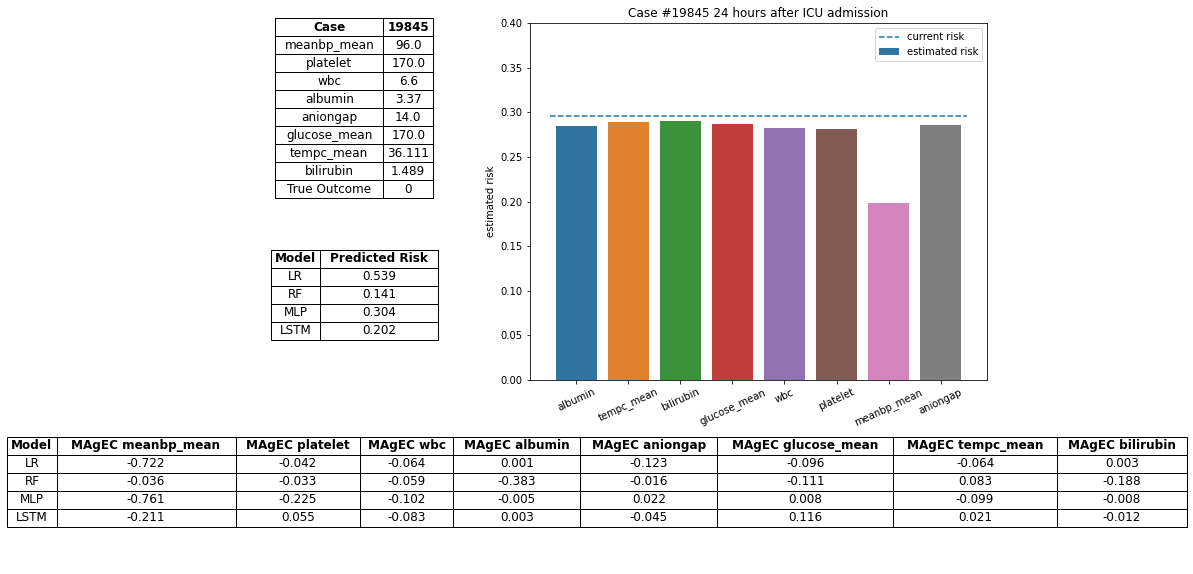

In [118]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=3,
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, 3), 
              title='Case #{} {} hours after ICU admission'.format(case, txt2))

In [101]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

set()

### Find interesting patients for whom we have annotations

In [ ]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours',
        'age', 'gender', 'ethnicity']

valid_cases = df_cohort[np.isin(df_cohort.subject_id, users)].\
               sort_values(['subject_id', 'timepoint']).\
               groupby(['subject_id'])[cols].first()

In [ ]:
valid_cases[valid_cases['mv_hours'] > 0]

### Potential new cases

In [ ]:
# 6451, 19823
case = 29043
df_anno[df_anno.SUBJECT_ID==case].iloc[0]

In [ ]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

In [ ]:
t_min = df_cohort[df_cohort.subject_id==case]['timepoint'].min()
t_max = df_cohort[df_cohort.subject_id==case]['timepoint'].max()
print(t_min, t_max)

In [ ]:
timepoint = t_max
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
timepoint = t_min
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)